In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable 
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from torchvision import datasets, transforms
# from PIL import Image

In [3]:
BATCH_SIZE=32 #大概需要2G的显存
EPOCHS=5
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

mnist_train = pd.read_csv('mnist_train.csv')
mnist_test=pd.read_csv('mnist_test.csv')

nrow = 28
ncol = 28

In [4]:
def left_top(x):
    nsam = x.shape[0]
    nrow = x.shape[1]
    ncol = x.shape[2]
    z = np.zeros((nsam, nrow, ncol), dtype=np.double)
    data1 = np.concatenate((x, z), axis=1)
    data2 = np.concatenate((z, z), axis=1)
    data3 = np.concatenate((data1, data2), 2)
    return data3

def right_bottom(x):
    nsam = x.shape[0]
    nrow = x.shape[1]
    ncol = x.shape[2]
    z = np.zeros((nsam, nrow, ncol), dtype=np.double)
    data1 = np.concatenate((z, z), axis=1)
    data2 = np.concatenate((z, x), axis=1)
    data3 = np.concatenate((data1, data2), 2)
    return data3
def getType(dataset,x):
        index = np.where(dataset[:, 0] == x)
        for i in index:
            Type = dataset[i]
        return Type
def getPixel(x):
        pixel = x[:, 1:]
        return pixel
def getLabel(x):
        label = x[:, 0]
        return label

In [5]:
def train_data(dataset):
    
    train = dataset.values
    type0=getType(train,0)
    type1=getType(train,1)

    # X and label
    x0 = getPixel(type0)
    x1 =  getPixel(type1)
    y0 = getLabel(type0)
    y1 =  getLabel(type1)
    y1=y1-1+1
    y0=y0-y0
    
    # X reshape to 28 28
    nx1 = x1.shape[0]
    nx0 = x0.shape[0]
    x1_reshape = x1.reshape((nx1, nrow, ncol))
    x0_reshape = x0.reshape((nx0, nrow, ncol))

    left0 = left_top(x0_reshape)
    right1 = right_bottom(x1_reshape)
    target = np.concatenate((left0, right1), axis=0)

    target = torch.from_numpy(target)
    target = torch.unsqueeze(target, 1)
    label = np.concatenate((y0, y1), axis=0)

    label=torch.from_numpy(label)
    return target,label

In [6]:
xtr,ytr=train_data(mnist_train)

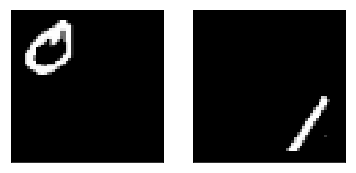

In [9]:
import matplotlib
import matplotlib.pyplot as plt
def plt_digit(x):
    nrow = 56
    ncol = 56
    xsq = x.reshape((nrow,ncol))
    plt.imshow(xsq,  cmap='Greys_r')
    plt.xticks([])
    plt.yticks([])

plt.subplot(1,2,1)
plt_digit(xtr[1,:])
plt.subplot(1,2,2)
plt_digit(xtr[10000,:])
plt.savefig('3.png')




In [6]:
import matplotlib
import matplotlib.pyplot as plt
def plt_digit(x):
    nrow = 56
    ncol = 56
    xsq = x.reshape((nrow,ncol))
    plt.imshow(xsq,  cmap='Greys_r')
    plt.xticks([])
    plt.yticks([])

plt.subplot(1,2,1)
plt_digit(xtr[1,:])
plt.subplot(1,2,2)
plt_digit(xtr[10000,:])



In [10]:
class train(Dataset):
    def __init__(self):
        
        self.len = ytr.shape[0]
        self.x_data = xtr
        self.y_data = ytr
        # self.transform = transform

    def __getitem__(self, index):
#         if self.transform:
#             x = self.transform(x)
        #img = Image.fromarray(self.x_data[index])
        return self.x_data[index], self.y_data[index]
      

    def __len__(self):
        return self.len
trainset= train()
train_loader = DataLoader(dataset=trainset,
                          batch_size=32,
                          shuffle=True,
                          num_workers=2)

In [11]:
def test_data(dataset):
    
    test = dataset.values
    type0=getType(test,0)
    type1=getType(test,1)
    
    # X and label
    x0 = getPixel(type0)
    x1 =  getPixel(type1)
    y0 = getLabel(type0)
    y1 =  getLabel(type1)
    y1=y1-1+1
    y0=y0-y0
    
    # X reshape to 28 28
    nx1 = x1.shape[0]
    nx0 = x0.shape[0]
    x1_reshape = x1.reshape((nx1, nrow, ncol))
    x0_reshape = x0.reshape((nx0, nrow, ncol))

    right0 = right_bottom(x0_reshape)
    left1 = left_top(x1_reshape)
    target = np.concatenate((right0, left1), axis=0)

    target = torch.from_numpy(target)
    target = torch.unsqueeze(target, 1)
    label = np.concatenate((y0, y1), axis=0)

    label=torch.from_numpy(label)
    return target,label

In [12]:
xts,yts=test_data(mnist_test)

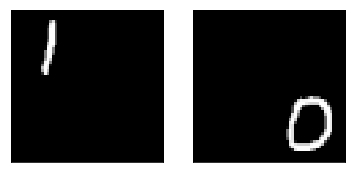

In [14]:
import matplotlib
import matplotlib.pyplot as plt
def plt_digit(x):
    nrow = 56
    ncol = 56
    xsq = x.reshape((nrow,ncol))
    plt.imshow(xsq,  cmap='Greys_r')
    plt.xticks([])
    plt.yticks([])

plt.subplot(1,2,1)
plt_digit(xts[1100,:])

plt.subplot(1,2,2)
plt_digit(xts[1,:])
plt.savefig('4.png')



In [11]:
class test(Dataset):
    def __init__(self):
  
     
        self.len = yts.shape[0]

        self.x_data = xts

        self.y_data = yts
        
        # self.transform = transform

    def __getitem__(self, index):
        # img = Image.fromarray(self.x_data[index])
        return self.x_data[index], self.y_data[index]

    def __len__(self):
        return self.len
testset = test()
test_loader = DataLoader(dataset=testset,
                          batch_size=32,
                          shuffle=True,
                          num_workers=2)

In [12]:
class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        # 1,28x28
        self.conv1=nn.Conv2d(1,10,5) # 10, 24x24
        self.conv2=nn.Conv2d(10,20,3) # 128, 10x10
        self.fc1 = nn.Linear(2880,300)
        self.fc2 = nn.Linear(300,2)
    def forward(self,x):
        in_size = x.size(0)
        out = self.conv1(x) #24
        out = F.relu(out)
        out = F.max_pool2d(out, 2, 2)  #12
        out = self.conv2(out) #10
        out = F.relu(out)
        out = F.max_pool2d(out, 2, 2)  #12
        out = F.relu(out)   
        out = out.view(in_size,-1)
        out = self.fc1(out)
        out = F.relu(out)
        out = self.fc2(out)
        # out = F.log_softmax(out,dim=1)
        # out = F.softmax(out,dim=1)
        return out

In [13]:
model = ConvNet()
model = model.to(DEVICE)
model= model.double()
optimizer = optim.Adam(model.parameters())
# criterion = nn.CrossEntropyLoss()

In [14]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        # print(data.size(), target.size())
        optimizer.zero_grad()
        output=model(data)
        # print(output)
        #print(target)
        # loss = F.nll_loss(output, target)
        # print(loss)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
        if(batch_idx+1)%50 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data.double())
#             print(output)
            test_loss += F.cross_entropy(output, target, reduction='sum').item() # 将一批的损失相加
            pred = output.max(1, keepdim=True)[1] # 找到概率最大的下标
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.4f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))






In [15]:
for epoch in range(1, EPOCHS + 1):
    train(model, DEVICE, train_loader, optimizer, epoch)
    test(model, DEVICE, test_loader)

Train Epoch: 1 [1568/12665 (12%)]	Loss: 0.000000
Train Epoch: 1 [3168/12665 (25%)]	Loss: 0.000000
Train Epoch: 1 [4768/12665 (38%)]	Loss: 0.000000
Train Epoch: 1 [6368/12665 (50%)]	Loss: 0.000000
Train Epoch: 1 [7968/12665 (63%)]	Loss: 0.000000
Train Epoch: 1 [9568/12665 (76%)]	Loss: 0.000000
Train Epoch: 1 [11168/12665 (88%)]	Loss: 0.000000

Test set: Average loss: 173.7984, Accuracy: 0/2115 (0.0000%)

Train Epoch: 2 [1568/12665 (12%)]	Loss: 0.000000
Train Epoch: 2 [3168/12665 (25%)]	Loss: 0.000000
Train Epoch: 2 [4768/12665 (38%)]	Loss: 0.000000
Train Epoch: 2 [6368/12665 (50%)]	Loss: 0.000000
Train Epoch: 2 [7968/12665 (63%)]	Loss: 0.000000
Train Epoch: 2 [9568/12665 (76%)]	Loss: 0.000000
Train Epoch: 2 [11168/12665 (88%)]	Loss: 0.000000

Test set: Average loss: 173.7984, Accuracy: 0/2115 (0.0000%)

Train Epoch: 3 [1568/12665 (12%)]	Loss: 0.000000
Train Epoch: 3 [3168/12665 (25%)]	Loss: 0.000000
Train Epoch: 3 [4768/12665 (38%)]	Loss: 0.000000
Train Epoch: 3 [6368/12665 (50%)]	Loss: